In [1336]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model, optimizers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Input, Embedding, Bidirectional, LSTM, 
                                     Dense, RepeatVector, Flatten, BatchNormalization, 
                                     LeakyReLU, Dropout)
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import seaborn as sns
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ben.prescott\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Importing Full Corpus

In [4]:
# Load JSON lines file for the full corpus
corpus = []
with open('redditjson.jl', encoding='utf8') as f:
    for line in f:
        corpus.append(json.loads(line))

In [1255]:
corpusDF.subreddit.unique()

array(['singapore', 'tifu', 'cringepics', 'motorcycles',
       'TwoXChromosomes', 'hockey', 'sex', 'Christianity', 'conspiracy',
       'canada', 'pokemontrades', 'Guildwars2', 'askscience', 'IAmA',
       'australia', 'relationships', 'Bitcoin', 'business',
       'electronic_cigarette', 'MMA', 'DebateReligion', 'skyrim',
       'movies', 'WTF', 'Android', 'OkCupid', 'Frugal', 'anime',
       'todayilearned', 'Fitness', 'SquaredCircle', 'photography',
       'hiphopheads', 'POLITIC', 'apple', 'science', 'AskMen', 'pokemon',
       'offbeat', 'Games', 'Minecraft', 'guns', 'AskWomen', 'politics',
       'technology', 'wow', 'Music', 'tf2', 'cringe', 'techsupport',
       'news', 'cars', 'MensRights', 'malefashionadvice', 'buildapc',
       'worldnews', 'gifs', 'soccer', 'asoiaf', 'explainlikeimfive',
       'dayz', 'books', 'relationship_advice', 'aww', 'gonewild',
       'fantasyfootball', 'unitedkingdom', 'AmItheAsshole',
       'MovieDetails', 'nfl', 'AdviceAnimals', 'programming', 

## Select Only Games Subreddit

In [1350]:
corpusDF = pd.DataFrame(corpus) # Assign corpus to dataframe for ease of review 

reddits = ['Games'] # Subreddits I want to include in my analysis 

reducedDF = corpusDF[corpusDF['subreddit'].isin(reddits)] # Creating a new dataframe consisting of only Games subreddit

In [1351]:
# Removing empty, deleted, removed, and automoderate utterances
reducedDF = reducedDF[~(reducedDF['text'] == '') & 
                      ~(reducedDF['text'] == '[deleted]') & 
                      ~(reducedDF['text'] == '[removed]') &
                      ~(reducedDF['speaker'] == 'AutoModerator')
                     ]

## VADER

In [1352]:
# Loading the VADER model 
analyzer = SentimentIntensityAnalyzer()

In [1353]:
# Creating a copy of the Games dataframe and assigning a new column all values of zero
reducedScored = reducedDF.copy()
reducedScored['sentiment'] = 0
comments = reducedScored.text.tolist()

In [1354]:
len(comments)

3542

In [1355]:
# Performing sentiment analysis on each utterance and updating the 'sentiment' column score
reducedScored = reducedDF.copy()
reducedScored.reset_index(inplace=True)
reducedScored['sentiment'] = 0
comments = reducedScored.text.tolist()
count = 0
for comment in comments:
    score = analyzer.polarity_scores(comment)
    if score['compound'] > 0.05:
        reducedScored.at[count, 'sentiment'] = 1
    else:
        reducedScored.at[count, 'sentiment'] = 0
    count += 1

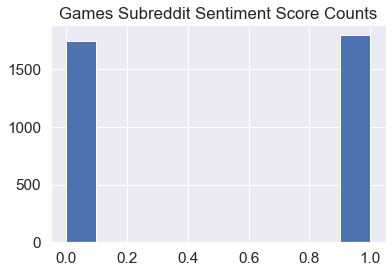

In [1357]:
# Visualizing the sentiment score counts
plt.hist(reducedScored.sentiment)
plt.title('Games Subreddit Sentiment Score Counts')
plt.show()

## Tokenization and Padding

In [1316]:
# Converting the utterances and their VADER sentiment labels to lists
sentences = reducedScored.text.tolist()
labels = np.array(reducedScored.sentiment.tolist())

In [1317]:
# Reviewing the max sequence lengths to use for variables later
# Some look to be outliers - possibly long URLs. Majority seem to be under 55 words long.
seq_lengths = reducedScored.text.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    3542.000000
mean       50.200169
std       128.529918
min         1.000000
25%        16.000000
50%        29.000000
75%        55.000000
max      5203.000000
Name: text, dtype: float64

In [1318]:
# Selecting some values for tokenization and word embeddings.
num_words = 300
max_len = 200
embed_dim = 10

In [1319]:
# Tokenizing and zero-padding the sequences
tokenizer = Tokenizer(num_words = num_words,
                      split=' ')
tokenizer.fit_on_texts(sentences)
seqs = tokenizer.texts_to_sequences(sentences)
pad_seqs = pad_sequences(seqs, max_len)

In [1320]:
len(pad_seqs[1])

200

## Word Embeddings Using AutoEncoder

In [1321]:
# Tripartite splitting of the datasets
X, y = pad_seqs, labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [1322]:
print('X_train:',X_train.shape,'\n','X_test:',X_test.shape,'\n','X_val:',X_val.shape)

X_train: (2390, 200) 
 X_test: (355, 200) 
 X_val: (797, 200)


In [1323]:
# define encoder/decoder
visible = Input(shape=(max_len,))
# encoder layer 1
encoder = Dense(max_len*2)(visible)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)
# encoder layer 2
encoder = Dense(max_len)(encoder)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)
# reduction
n_bottleneck = max_len
bottleneck = Dense(n_bottleneck)(encoder)

# decoder layer 1
decoder = Dense(max_len)(bottleneck)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder layer 2
decoder = Dense(max_len*2)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# output layer
output = Dense(max_len, activation='linear')(decoder)

gc.collect()

escallback = EarlyStopping(monitor='val_loss', patience=3)

model = Model(inputs=visible, outputs=output)
model.summary()
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, 
          X_train, 
          epochs=100, 
          validation_data=(X_val,X_val), 
          callbacks=[escallback])

encoder = Model(inputs=visible, outputs=bottleneck)
encoder.save('encoder.h5')

Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
dense_564 (Dense)            (None, 400)               80400     
_________________________________________________________________
batch_normalization_93 (Batc (None, 400)               1600      
_________________________________________________________________
leaky_re_lu_114 (LeakyReLU)  (None, 400)               0         
_________________________________________________________________
dense_565 (Dense)            (None, 200)               80200     
_________________________________________________________________
batch_normalization_94 (Batc (None, 200)               800       
_________________________________________________________________
leaky_re_lu_115 (LeakyReLU)  (None, 200)               0  

In [1324]:
# Predicting the word embeddings for the X value train/test/validation data
X_train_encode = encoder.predict(X_train)
X_test_encode = encoder.predict(X_test)
X_val_encode = encoder.predict(X_val)

## Classification Network

In [1346]:
# Model used to predict the sentiment scores using the learned word embeddings
model = Sequential()
model.add(Dense(128, input_dim=max_len, activation='relu'))
model.add(Dense(12, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
escallback = EarlyStopping(monitor='val_loss', patience=5)

gc.collect()
model.fit(X_train_encode, 
          y_train,
          validation_data = (X_val_encode,y_val),
          callbacks=[escallback],
          epochs=50)

Epoch 1/50
75/75 [==============================] - 1s 4ms/step - loss: 0.7406 - accuracy: 0.5183 - val_loss: 0.6920 - val_accuracy: 0.5471
Epoch 2/50
75/75 [==============================] - 0s 2ms/step - loss: 0.6621 - accuracy: 0.5811 - val_loss: 0.7089 - val_accuracy: 0.5684
Epoch 3/50
75/75 [==============================] - 0s 3ms/step - loss: 0.6250 - accuracy: 0.6424 - val_loss: 0.7306 - val_accuracy: 0.5521
Epoch 4/50
75/75 [==============================] - 0s 3ms/step - loss: 0.6011 - accuracy: 0.6726 - val_loss: 0.7424 - val_accuracy: 0.5646
Epoch 5/50
75/75 [==============================] - 0s 3ms/step - loss: 0.5609 - accuracy: 0.6947 - val_loss: 0.7634 - val_accuracy: 0.5634
Epoch 6/50
75/75 [==============================] - 0s 3ms/step - loss: 0.5384 - accuracy: 0.7181 - val_loss: 0.7946 - val_accuracy: 0.5445


## Sentiment Predictions & Performance

In [1347]:
# Predicting sentiment scores for the X_Test word embeddings
pred = (model.predict(X_test_encode) > 0.5).astype("int32")
predDF = pd.DataFrame({'actual':y_test.tolist(),'predicted':[item for sublist in pred for item in sublist]})
predDF

,actual,predicted
0,1,1
1,1,1
2,0,1
3,0,0
4,1,1
...,...,...
350,0,1
351,1,1
352,0,0
353,1,1


### ROC Curve

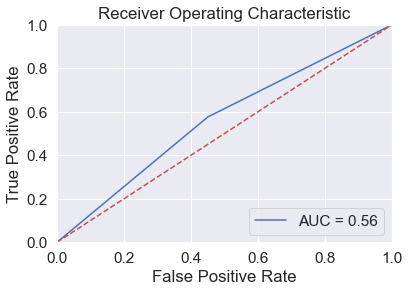

In [1348]:
# Reviewing ROC AUC score

fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr,tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Confusion Matrix

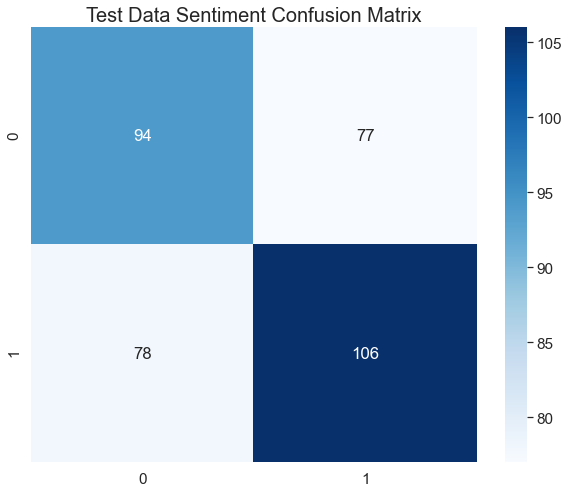

In [1349]:
# Reviewing the confusion matrix of correctly and incorrectly classified data

cm = confusion_matrix(predDF.actual,predDF.predicted)
plt.figure(figsize=(10,8))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,cmap='Blues',fmt='d')
plt.title('Test Data Sentiment Confusion Matrix', fontsize=20)
plt.show()